# import necessary modules

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
from torchvision.utils import save_image

import numpy as np
from matplotlib import pyplot as plt
import PIL
import model
from tqdm import tqdm
import random

# load data and make data loader

In [2]:
GTSRB_train_x_128 = torch.load('GTSRB_train_x.pt')
GTSRB_train_y_128 = torch.load('GTSRB_train_y.pt')
GTSRB_test_x_128 = torch.load('GTSRB_test_x.pt')
GTSRB_test_y_128 = torch.load('GTSRB_test_y.pt')

In [3]:
print(GTSRB_train_x_128.size())
print(GTSRB_train_y_128.size())
print(GTSRB_test_x_128.size())
print(GTSRB_test_y_128.size())

torch.Size([39209, 3, 128, 128])
torch.Size([39209])
torch.Size([12630, 3, 128, 128])
torch.Size([12630])


In [4]:
batch_size = 200
train_set = TensorDataset(GTSRB_train_x_128, GTSRB_train_y_128)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_set = TensorDataset(GTSRB_test_x_128, GTSRB_test_y_128)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_set = TensorDataset(GTSRB_test_x_128, GTSRB_test_y_128)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

# visualize the dataset

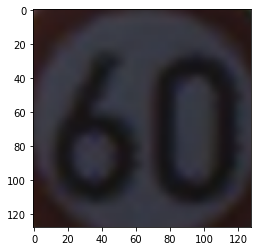

In [5]:
def CHW_to_HWC(x):
    pixels = np.copy(x)
    pixels = np.swapaxes(pixels,0,2)
    pixels = np.swapaxes(pixels,1,0)
    return pixels

def HWC_to_CHW(x):
    pixels = np.copy(x)
    pixels = np.swapaxes(pixels,0,2)
    pixels = np.swapaxes(pixels,1,2)
    return pixels


plt.imshow(CHW_to_HWC(GTSRB_train_x_128[5000].numpy()))
plt.show()

# training setup

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 100
lr = 0.0005
criterion = nn.BCELoss()

In [7]:
encoder_decoder = model.EncoderDecoder().to(device)
discriminator = model.Discriminator().to(device)
opt_enc_dec = optim.Adam(encoder_decoder.parameters(), lr=lr)
opt_disc = optim.Adam(discriminator.parameters(), lr=lr)

# training function

In [8]:
def fit(encoder_decoder, discriminator, dataloader, opt_enc_dec, opt_disc):
    encoder_decoder.train()
    discriminator.train()
    running_loss = 0.0
    M = torch.zeros((3,128,128))
    M[:,32:96,32:96] = 1
    M = M.to(device)
    for i, (data, label) in tqdm(enumerate(dataloader), total=int(len(dataloader.dataset)/dataloader.batch_size)):
        data = data.to(device) # 200, 3, 128, 128
        masked_data = data*(1-M)
        recovered_data = torch.clone(masked_data).to(device)
        gened_mask = encoder_decoder.forward(masked_data) # 200, 3, 64, 64
        recovered_data[:,:,32:96,32:96] = gened_mask # 200, 3, 128, 128
        
        ### Train Discriminator max log(D(x)) + log(1 - D(G(z)))
        disc_real = discriminator(data).reshape(-1) # N
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = discriminator(recovered_data).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        discriminator.zero_grad()
        loss_disc.backward(retain_graph=True)
        opt_disc.step()
        
        ### train encoder_decoder
        encoder_decoder.zero_grad()
        disc_gened = discriminator(masked_data).reshape(-1)
        adv_loss = criterion(disc_gened, torch.ones_like(disc_gened))
        rec_loss = torch.norm(M * (data - recovered_data))**2
        loss = 5*adv_loss + rec_loss
        running_loss += loss.item()
        loss.backward()
        opt_enc_dec.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

# validation function

In [9]:
def validate(encoder_decoder, discriminator, dataloader):
    encoder_decoder.eval()
    discriminator.eval()
    running_loss = 0.0
    M = torch.zeros((3,128,128))
    M[:,32:96,32:96] = 1
    M = M.to(device)
    with torch.no_grad():
        for i, (data, label) in tqdm(enumerate(dataloader), total=int(len(dataloader.dataset)/dataloader.batch_size)):
            data = data.to(device) # 200, 3, 128, 128
            masked_data = data*(1-M)
            gened_mask = encoder_decoder.forward(masked_data) # 200, 3, 64, 64
            masked_data[:,:,32:96,32:96] = gened_mask # 200, 3, 128, 128
            disc_gened = discriminator(masked_data).reshape(-1)
            adv_loss = criterion(disc_gened, torch.ones_like(disc_gened))
            rec_loss = torch.norm(M * (data - masked_data))**2
            loss = adv_loss + rec_loss
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(dataloader.dataset)/dataloader.batch_size) - 1:
                num_rows = 4
                both = torch.cat((data.view(batch_size, 3, 128, 128)[:4], 
                                  masked_data.view(batch_size, 3, 128, 128)[:4]))
                save_image(both.cpu(), f"./outputs/output{epoch}.png", nrow=num_rows)
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

In [10]:
train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(encoder_decoder, discriminator, train_loader, opt_enc_dec, opt_disc)
    val_epoch_loss = validate(encoder_decoder, discriminator, val_loader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")
    torch.save(encoder_decoder.state_dict(), 'encoder_decoder.pth')
    torch.save(discriminator.state_dict(), 'discriminator.pth')

  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 1 of 50


197it [03:30,  1.07s/it]                                                                                               
64it [00:11,  5.69it/s]                                                                                                


Train Loss: 553.9681
Val Loss: 311.1989


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 2 of 50


197it [03:29,  1.06s/it]                                                                                               
64it [00:13,  4.87it/s]                                                                                                


Train Loss: 235.8357
Val Loss: 258.3241


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 3 of 50


197it [03:40,  1.12s/it]                                                                                               
64it [00:11,  5.61it/s]                                                                                                


Train Loss: 186.6908
Val Loss: 253.1760


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 4 of 50


197it [03:38,  1.11s/it]                                                                                               
64it [00:11,  5.59it/s]                                                                                                


Train Loss: 147.0311
Val Loss: 124.6964


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 5 of 50


197it [03:36,  1.10s/it]                                                                                               
64it [00:10,  5.83it/s]                                                                                                


Train Loss: 99.6799
Val Loss: 94.0930


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 6 of 50


197it [03:37,  1.10s/it]                                                                                               
64it [00:11,  5.61it/s]                                                                                                


Train Loss: 71.7134
Val Loss: 105.5032


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 7 of 50


197it [03:43,  1.13s/it]                                                                                               
64it [00:12,  5.24it/s]                                                                                                


Train Loss: 64.6973
Val Loss: 72.0369


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 8 of 50


197it [03:49,  1.17s/it]                                                                                               
64it [00:11,  5.36it/s]                                                                                                


Train Loss: 52.7134
Val Loss: 75.6890


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 9 of 50


197it [03:34,  1.09s/it]                                                                                               
64it [00:12,  5.03it/s]                                                                                                


Train Loss: 49.2324
Val Loss: 70.2576


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 10 of 50


197it [03:49,  1.17s/it]                                                                                               
64it [00:12,  5.13it/s]                                                                                                


Train Loss: 45.0386
Val Loss: 63.3485


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 11 of 50


197it [03:25,  1.04s/it]                                                                                               
64it [00:11,  5.77it/s]                                                                                                


Train Loss: 41.4163
Val Loss: 59.6859


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 12 of 50


197it [03:32,  1.08s/it]                                                                                               
64it [00:11,  5.71it/s]                                                                                                


Train Loss: 37.1631
Val Loss: 57.2496


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 13 of 50


197it [03:31,  1.08s/it]                                                                                               
64it [00:11,  5.71it/s]                                                                                                


Train Loss: 38.7589
Val Loss: 101.7265


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 14 of 50


197it [03:29,  1.06s/it]                                                                                               
64it [00:11,  5.70it/s]                                                                                                


Train Loss: 34.3764
Val Loss: 54.3040


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 15 of 50


197it [03:36,  1.10s/it]                                                                                               
64it [00:11,  5.66it/s]                                                                                                


Train Loss: 32.6892
Val Loss: 51.8188


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 16 of 50


197it [03:28,  1.06s/it]                                                                                               
64it [00:11,  5.60it/s]                                                                                                


Train Loss: 29.7775
Val Loss: 169.1006


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 17 of 50


197it [03:28,  1.06s/it]                                                                                               
64it [00:11,  5.71it/s]                                                                                                


Train Loss: 38.5722
Val Loss: 51.9062


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 18 of 50


197it [03:28,  1.06s/it]                                                                                               
64it [00:11,  5.64it/s]                                                                                                


Train Loss: 27.1523
Val Loss: 50.8437


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 19 of 50


197it [03:22,  1.03s/it]                                                                                               
64it [00:10,  5.95it/s]                                                                                                


Train Loss: 26.1023
Val Loss: 62.3117


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 20 of 50


197it [03:24,  1.04s/it]                                                                                               
64it [00:11,  5.79it/s]                                                                                                


Train Loss: 28.9722
Val Loss: 49.6272


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 21 of 50


197it [03:25,  1.04s/it]                                                                                               
64it [00:10,  5.83it/s]                                                                                                


Train Loss: 24.3505
Val Loss: 64.1624


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 22 of 50


197it [03:28,  1.06s/it]                                                                                               
64it [00:11,  5.81it/s]                                                                                                


Train Loss: 27.7126
Val Loss: 50.7721


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 23 of 50


197it [03:24,  1.04s/it]                                                                                               
64it [00:11,  5.80it/s]                                                                                                


Train Loss: 23.9927
Val Loss: 47.3538


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 24 of 50


197it [03:27,  1.05s/it]                                                                                               
64it [00:11,  5.76it/s]                                                                                                


Train Loss: 21.3392
Val Loss: 48.2428


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 25 of 50


197it [03:25,  1.04s/it]                                                                                               
64it [00:11,  5.77it/s]                                                                                                


Train Loss: 23.0518
Val Loss: 57.7836


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 26 of 50


197it [03:26,  1.05s/it]                                                                                               
64it [00:11,  5.78it/s]                                                                                                


Train Loss: 23.7527
Val Loss: 46.3681


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 27 of 50


197it [03:28,  1.06s/it]                                                                                               
64it [00:11,  5.77it/s]                                                                                                


Train Loss: 19.6800
Val Loss: 46.1817


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 28 of 50


197it [03:25,  1.04s/it]                                                                                               
64it [00:11,  5.75it/s]                                                                                                


Train Loss: 27.1926
Val Loss: 48.4414


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 29 of 50


197it [03:25,  1.04s/it]                                                                                               
64it [00:11,  5.79it/s]                                                                                                


Train Loss: 19.2985
Val Loss: 45.7816


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 30 of 50


197it [03:25,  1.04s/it]                                                                                               
64it [00:11,  5.76it/s]                                                                                                


Train Loss: 17.9606
Val Loss: 51.4519


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 31 of 50


197it [03:25,  1.04s/it]                                                                                               
64it [00:11,  5.80it/s]                                                                                                


Train Loss: 18.3832
Val Loss: 44.6890


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 32 of 50


197it [03:24,  1.04s/it]                                                                                               
64it [00:10,  5.84it/s]                                                                                                


Train Loss: 17.7709
Val Loss: 45.5428


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 33 of 50


197it [03:24,  1.04s/it]                                                                                               
64it [00:11,  5.80it/s]                                                                                                


Train Loss: 17.5518
Val Loss: 54.6716


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 34 of 50


197it [03:20,  1.02s/it]                                                                                               
64it [00:11,  5.75it/s]                                                                                                


Train Loss: 20.6560
Val Loss: 45.3853


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 35 of 50


197it [03:24,  1.04s/it]                                                                                               
64it [00:10,  5.87it/s]                                                                                                


Train Loss: 16.2868
Val Loss: 61.6145


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 36 of 50


197it [03:23,  1.03s/it]                                                                                               
64it [00:11,  5.77it/s]                                                                                                


Train Loss: 16.4001
Val Loss: 46.6531


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 37 of 50


197it [03:23,  1.03s/it]                                                                                               
64it [00:11,  5.81it/s]                                                                                                


Train Loss: 15.6668
Val Loss: 50.0607


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 38 of 50


197it [03:23,  1.03s/it]                                                                                               
64it [00:11,  5.72it/s]                                                                                                


Train Loss: 24.9155
Val Loss: 45.9842


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 39 of 50


197it [03:34,  1.09s/it]                                                                                               
64it [00:10,  6.02it/s]                                                                                                


Train Loss: 14.8223
Val Loss: 43.6262


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 40 of 50


197it [03:15,  1.01it/s]                                                                                               
64it [00:10,  6.01it/s]                                                                                                


Train Loss: 14.2335
Val Loss: 49.5579


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 41 of 50


197it [03:16,  1.00it/s]                                                                                               
64it [00:11,  5.57it/s]                                                                                                


Train Loss: 15.9909
Val Loss: 46.9155


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 42 of 50


197it [03:20,  1.02s/it]                                                                                               
64it [00:10,  6.02it/s]                                                                                                


Train Loss: 13.6911
Val Loss: 44.2950


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 43 of 50


197it [03:22,  1.03s/it]                                                                                               
64it [00:11,  5.68it/s]                                                                                                


Train Loss: 12.9604
Val Loss: 46.5176


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 44 of 50


197it [03:33,  1.09s/it]                                                                                               
64it [00:11,  5.63it/s]                                                                                                


Train Loss: 29.5541
Val Loss: 44.3202


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 45 of 50


197it [03:32,  1.08s/it]                                                                                               
64it [00:11,  5.77it/s]                                                                                                


Train Loss: 13.5888
Val Loss: 47.3209


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 46 of 50


197it [03:25,  1.04s/it]                                                                                               
64it [00:11,  5.74it/s]                                                                                                


Train Loss: 13.0989
Val Loss: 43.1559


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 47 of 50


197it [03:25,  1.04s/it]                                                                                               
64it [00:11,  5.79it/s]                                                                                                


Train Loss: 11.8999
Val Loss: 42.9414


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 48 of 50


197it [03:25,  1.04s/it]                                                                                               
64it [00:11,  5.79it/s]                                                                                                


Train Loss: 11.7787
Val Loss: 43.4492


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 49 of 50


197it [03:26,  1.05s/it]                                                                                               
64it [00:10,  6.02it/s]                                                                                                


Train Loss: 11.6860
Val Loss: 43.7828


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 50 of 50


197it [03:24,  1.04s/it]                                                                                               
64it [00:11,  5.76it/s]                                                                                                


Train Loss: 11.9873
Val Loss: 44.0879


# Ablation study - training without adversial loss

# training set up

In [11]:
encoder_decoder = model.EncoderDecoder().to(device)
opt_enc_dec = optim.Adam(encoder_decoder.parameters(), lr=lr)

# training function

In [12]:
def fit_abl(encoder_decoder, dataloader, opt_enc_dec):
    encoder_decoder.train()
    running_loss = 0.0
    M = torch.zeros((3,128,128))
    M[:,32:96,32:96] = 1
    M = M.to(device)
    for i, (data, label) in tqdm(enumerate(dataloader), total=int(len(dataloader.dataset)/dataloader.batch_size)):
        data = data.to(device) # 200, 3, 128, 128
        masked_data = data*(1-M)
        recovered_data = torch.clone(masked_data).to(device)
        gened_mask = encoder_decoder.forward(masked_data) # 200, 3, 64, 64
        recovered_data[:,:,32:96,32:96] = gened_mask # 200, 3, 128, 128
        
        ### train encoder_decoder
        encoder_decoder.zero_grad()
        rec_loss = torch.norm(M * (data - recovered_data))**2
        loss = rec_loss
        running_loss += loss.item()
        loss.backward()
        opt_enc_dec.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

# validation function

In [13]:
def validate_abl(encoder_decoder, dataloader):
    encoder_decoder.eval()
    running_loss = 0.0
    M = torch.zeros((3,128,128))
    M[:,32:96,32:96] = 1
    M = M.to(device)
    with torch.no_grad():
        for i, (data, label) in tqdm(enumerate(dataloader), total=int(len(dataloader.dataset)/dataloader.batch_size)):
            data = data.to(device) # 200, 3, 128, 128
            masked_data = data*(1-M)
            gened_mask = encoder_decoder.forward(masked_data) # 200, 3, 64, 64
            masked_data[:,:,32:96,32:96] = gened_mask # 200, 3, 128, 128
            rec_loss = torch.norm(M * (data - masked_data))**2
            loss = rec_loss
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(dataloader.dataset)/dataloader.batch_size) - 1:
                num_rows = 4
                both = torch.cat((data.view(batch_size, 3, 128, 128)[:4], 
                                  masked_data.view(batch_size, 3, 128, 128)[:4]))
                save_image(both.cpu(), f"./outputs/output{epoch}.png", nrow=num_rows)
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

In [14]:
train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit_abl(encoder_decoder, train_loader, opt_enc_dec)
    val_epoch_loss = validate_abl(encoder_decoder, val_loader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")
    torch.save(encoder_decoder.state_dict(), 'encoder_decoder.pth')# testing trained model

  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 1 of 50


197it [01:02,  3.15it/s]                                                                                               
64it [00:09,  6.71it/s]                                                                                                


Train Loss: 443.0921
Val Loss: 285.9769


  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.67it/s]

Epoch 2 of 50


197it [01:00,  3.25it/s]                                                                                               
64it [00:09,  6.85it/s]                                                                                                


Train Loss: 329.1459
Val Loss: 221.9934


  1%|▍                                                                                 | 1/196 [00:00<00:30,  6.45it/s]

Epoch 3 of 50


197it [01:00,  3.25it/s]                                                                                               
64it [00:09,  6.87it/s]                                                                                                


Train Loss: 190.2870
Val Loss: 174.1247


  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.62it/s]

Epoch 4 of 50


197it [01:00,  3.26it/s]                                                                                               
64it [00:09,  6.85it/s]                                                                                                


Train Loss: 127.0765
Val Loss: 204.1616


  1%|▍                                                                                 | 1/196 [00:00<00:28,  6.73it/s]

Epoch 5 of 50


197it [01:08,  2.88it/s]                                                                                               
64it [00:09,  6.46it/s]                                                                                                


Train Loss: 87.7712
Val Loss: 94.5614


  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.60it/s]

Epoch 6 of 50


197it [01:04,  3.07it/s]                                                                                               
64it [00:09,  6.47it/s]                                                                                                


Train Loss: 71.7540
Val Loss: 82.5117


  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.62it/s]

Epoch 7 of 50


197it [01:03,  3.11it/s]                                                                                               
64it [00:09,  6.81it/s]                                                                                                


Train Loss: 59.7114
Val Loss: 77.8440


  1%|▍                                                                                 | 1/196 [00:00<00:27,  7.04it/s]

Epoch 8 of 50


197it [01:02,  3.14it/s]                                                                                               
64it [00:09,  6.58it/s]                                                                                                


Train Loss: 51.0812
Val Loss: 68.7941


  1%|▍                                                                                 | 1/196 [00:00<00:30,  6.43it/s]

Epoch 9 of 50


197it [01:03,  3.12it/s]                                                                                               
64it [00:09,  6.67it/s]                                                                                                


Train Loss: 47.8855
Val Loss: 63.9655


  1%|▍                                                                                 | 1/196 [00:00<00:28,  6.78it/s]

Epoch 10 of 50


197it [01:02,  3.17it/s]                                                                                               
64it [00:09,  6.73it/s]                                                                                                


Train Loss: 43.2981
Val Loss: 60.7274


  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.58it/s]

Epoch 11 of 50


197it [01:02,  3.16it/s]                                                                                               
64it [00:09,  6.63it/s]                                                                                                


Train Loss: 38.7188
Val Loss: 90.3833


  1%|▍                                                                                 | 1/196 [00:00<00:28,  6.87it/s]

Epoch 12 of 50


197it [01:02,  3.13it/s]                                                                                               
64it [00:09,  6.62it/s]                                                                                                


Train Loss: 43.5269
Val Loss: 56.5259


  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.71it/s]

Epoch 13 of 50


197it [01:01,  3.19it/s]                                                                                               
64it [00:09,  6.54it/s]                                                                                                


Train Loss: 33.5298
Val Loss: 55.6645


  1%|▍                                                                                 | 1/196 [00:00<00:28,  6.78it/s]

Epoch 14 of 50


197it [01:04,  3.06it/s]                                                                                               
64it [00:09,  7.06it/s]                                                                                                


Train Loss: 32.5573
Val Loss: 69.3050


  1%|▍                                                                                 | 1/196 [00:00<00:28,  6.87it/s]

Epoch 15 of 50


197it [01:04,  3.06it/s]                                                                                               
64it [00:09,  6.70it/s]                                                                                                


Train Loss: 32.5951
Val Loss: 53.1453


  1%|▍                                                                                 | 1/196 [00:00<00:28,  6.83it/s]

Epoch 16 of 50


197it [01:01,  3.21it/s]                                                                                               
64it [00:09,  6.74it/s]                                                                                                


Train Loss: 32.0649
Val Loss: 87.5755


  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.58it/s]

Epoch 17 of 50


197it [01:03,  3.11it/s]                                                                                               
64it [00:09,  6.63it/s]                                                                                                


Train Loss: 30.4057
Val Loss: 52.9314


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 18 of 50


197it [01:01,  3.18it/s]                                                                                               
64it [00:09,  6.63it/s]                                                                                                


Train Loss: 25.7408
Val Loss: 51.3809


  1%|▍                                                                                 | 1/196 [00:00<00:28,  6.90it/s]

Epoch 19 of 50


197it [01:02,  3.15it/s]                                                                                               
64it [00:09,  6.72it/s]                                                                                                


Train Loss: 33.2505
Val Loss: 58.7585


  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.64it/s]

Epoch 20 of 50


197it [01:01,  3.19it/s]                                                                                               
64it [00:09,  6.81it/s]                                                                                                


Train Loss: 24.8703
Val Loss: 57.0425


  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.58it/s]

Epoch 21 of 50


197it [01:01,  3.20it/s]                                                                                               
64it [00:10,  6.08it/s]                                                                                                


Train Loss: 25.2859
Val Loss: 52.0036


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 22 of 50


197it [01:00,  3.27it/s]                                                                                               
64it [00:09,  7.05it/s]                                                                                                


Train Loss: 21.7905
Val Loss: 57.5652


  1%|▍                                                                                 | 1/196 [00:00<00:28,  6.92it/s]

Epoch 23 of 50


197it [01:02,  3.18it/s]                                                                                               
64it [00:09,  6.74it/s]                                                                                                


Train Loss: 21.8733
Val Loss: 48.5904


  1%|▍                                                                                 | 1/196 [00:00<00:27,  7.17it/s]

Epoch 24 of 50


197it [01:03,  3.13it/s]                                                                                               
64it [00:14,  4.50it/s]                                                                                                


Train Loss: 20.6944
Val Loss: 48.4742


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 25 of 50


197it [01:01,  3.21it/s]                                                                                               
64it [00:09,  6.90it/s]                                                                                                


Train Loss: 20.0602
Val Loss: 80.7872


  1%|▍                                                                                 | 1/196 [00:00<00:28,  6.94it/s]

Epoch 26 of 50


197it [00:59,  3.29it/s]                                                                                               
64it [00:09,  6.93it/s]                                                                                                


Train Loss: 40.2858
Val Loss: 48.4712


  1%|▍                                                                                 | 1/196 [00:00<00:33,  5.85it/s]

Epoch 27 of 50


197it [01:05,  2.99it/s]                                                                                               
64it [00:09,  6.49it/s]                                                                                                


Train Loss: 19.3973
Val Loss: 48.0413


  1%|▍                                                                                 | 1/196 [00:00<00:27,  7.12it/s]

Epoch 28 of 50


197it [01:01,  3.19it/s]                                                                                               
64it [00:09,  6.94it/s]                                                                                                


Train Loss: 18.7588
Val Loss: 47.8337


  1%|▍                                                                                 | 1/196 [00:00<00:26,  7.25it/s]

Epoch 29 of 50


197it [01:00,  3.27it/s]                                                                                               
64it [00:09,  6.83it/s]                                                                                                


Train Loss: 19.1504
Val Loss: 46.1028


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 30 of 50


197it [01:04,  3.05it/s]                                                                                               
64it [00:10,  6.27it/s]                                                                                                


Train Loss: 18.1247
Val Loss: 48.7377


  1%|▍                                                                                 | 1/196 [00:00<00:30,  6.39it/s]

Epoch 31 of 50


197it [01:01,  3.18it/s]                                                                                               
64it [00:09,  6.85it/s]                                                                                                


Train Loss: 16.5760
Val Loss: 46.6547


  1%|▍                                                                                 | 1/196 [00:00<00:25,  7.52it/s]

Epoch 32 of 50


197it [00:58,  3.37it/s]                                                                                               
64it [00:09,  7.02it/s]                                                                                                


Train Loss: 15.8960
Val Loss: 51.6964


  1%|▍                                                                                 | 1/196 [00:00<00:27,  7.17it/s]

Epoch 33 of 50


197it [01:03,  3.08it/s]                                                                                               
64it [00:09,  6.63it/s]                                                                                                


Train Loss: 18.7032
Val Loss: 44.7586


  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 34 of 50


197it [01:05,  3.03it/s]                                                                                               
64it [00:09,  6.89it/s]                                                                                                


Train Loss: 15.0600
Val Loss: 45.8395


  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.62it/s]

Epoch 35 of 50


197it [01:00,  3.28it/s]                                                                                               
64it [00:09,  6.92it/s]                                                                                                


Train Loss: 14.5608
Val Loss: 50.1145


  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.51it/s]

Epoch 36 of 50


197it [00:59,  3.34it/s]                                                                                               
64it [00:08,  7.17it/s]                                                                                                


Train Loss: 15.1124
Val Loss: 44.6564


  1%|▍                                                                                 | 1/196 [00:00<00:27,  7.19it/s]

Epoch 37 of 50


197it [00:57,  3.40it/s]                                                                                               
64it [00:08,  7.13it/s]                                                                                                


Train Loss: 14.5121
Val Loss: 50.0978


  1%|▍                                                                                 | 1/196 [00:00<00:27,  7.17it/s]

Epoch 38 of 50


197it [00:57,  3.40it/s]                                                                                               
64it [00:08,  7.16it/s]                                                                                                


Train Loss: 21.4436
Val Loss: 48.0560


  1%|▍                                                                                 | 1/196 [00:00<00:28,  6.90it/s]

Epoch 39 of 50


197it [00:57,  3.41it/s]                                                                                               
64it [00:08,  7.18it/s]                                                                                                


Train Loss: 13.1897
Val Loss: 44.9788


  1%|▍                                                                                 | 1/196 [00:00<00:28,  6.76it/s]

Epoch 40 of 50


197it [00:57,  3.41it/s]                                                                                               
64it [00:08,  7.17it/s]                                                                                                


Train Loss: 12.2706
Val Loss: 44.5590


  1%|▍                                                                                 | 1/196 [00:00<00:27,  6.97it/s]

Epoch 41 of 50


197it [00:57,  3.41it/s]                                                                                               
64it [00:08,  7.17it/s]                                                                                                


Train Loss: 19.6165
Val Loss: 44.0157


  1%|▍                                                                                 | 1/196 [00:00<00:26,  7.24it/s]

Epoch 42 of 50


197it [00:57,  3.40it/s]                                                                                               
64it [00:08,  7.12it/s]                                                                                                


Train Loss: 11.7331
Val Loss: 43.1416


  1%|▍                                                                                 | 1/196 [00:00<00:27,  6.97it/s]

Epoch 43 of 50


197it [00:57,  3.41it/s]                                                                                               
64it [00:08,  7.15it/s]                                                                                                


Train Loss: 11.1825
Val Loss: 44.5575


  1%|▍                                                                                 | 1/196 [00:00<00:27,  7.22it/s]

Epoch 44 of 50


197it [00:57,  3.40it/s]                                                                                               
64it [00:08,  7.17it/s]                                                                                                


Train Loss: 17.5085
Val Loss: 43.5089


  1%|▍                                                                                 | 1/196 [00:00<00:27,  7.22it/s]

Epoch 45 of 50


197it [00:57,  3.41it/s]                                                                                               
64it [00:09,  7.09it/s]                                                                                                


Train Loss: 11.1477
Val Loss: 43.6692


  1%|▍                                                                                 | 1/196 [00:00<00:27,  6.97it/s]

Epoch 46 of 50


197it [00:57,  3.41it/s]                                                                                               
64it [00:08,  7.17it/s]                                                                                                


Train Loss: 10.3748
Val Loss: 42.5948


  1%|▍                                                                                 | 1/196 [00:00<00:27,  7.07it/s]

Epoch 47 of 50


197it [00:57,  3.40it/s]                                                                                               
64it [00:08,  7.12it/s]                                                                                                


Train Loss: 10.0548
Val Loss: 42.8415


  1%|▍                                                                                 | 1/196 [00:00<00:28,  6.85it/s]

Epoch 48 of 50


197it [00:57,  3.40it/s]                                                                                               
64it [00:08,  7.13it/s]                                                                                                


Train Loss: 10.1414
Val Loss: 44.1345


  1%|▍                                                                                 | 1/196 [00:00<00:26,  7.27it/s]

Epoch 49 of 50


197it [00:57,  3.40it/s]                                                                                               
64it [00:08,  7.18it/s]                                                                                                


Train Loss: 13.9930
Val Loss: 44.1211


  1%|▍                                                                                 | 1/196 [00:00<00:28,  6.83it/s]

Epoch 50 of 50


197it [00:57,  3.41it/s]                                                                                               
64it [00:08,  7.19it/s]                                                                                                


Train Loss: 10.1938
Val Loss: 43.2379


# testing trained model

In [26]:
trained_model = model.EncoderDecoder()
params = torch.load('encoder_decoder_GTSRB_abl.pth')
trained_model.load_state_dict(params)
trained_model = trained_model.to(device=device)

In [27]:
def test_inpainting(encoder_decoder, dataloader):
    encoder_decoder.eval()
    running_loss = 0.0
    M = torch.zeros((3,128,128))
    M[:,32:96,32:96] = 1
    M = M.to(device)
    with torch.no_grad():
        for i, (data, label) in tqdm(enumerate(dataloader), total=int(len(dataloader.dataset)/dataloader.batch_size)):
            data = data.to(device) # 200, 3, 128, 128
            masked_data = data*(1-M)
            hollow_data = torch.clone(masked_data).to(device)
            gened_mask = encoder_decoder.forward(masked_data) # 200, 3, 64, 64
            masked_data[:,:,32:96,32:96] = gened_mask # 200, 3, 128, 128
        
            num_rows = 10
            for j in range(int(data.size()[0] / 10)):
                both = torch.cat((data.view(data.size()[0], 3, 128, 128)[j*10:j*10+10], 
                                  hollow_data.view(data.size()[0], 3, 128, 128)[j*10:j*10+10],
                                  masked_data.view(data.size()[0], 3, 128, 128)[j*10:j*10+10]))
                save_image(both.cpu(), f"./tests_GTSRB_abl/output{i*20+j}.png", nrow=num_rows)
    return None

In [28]:
test_inpainting(trained_model, test_loader)

64it [03:47,  3.56s/it]                                                                                                


# random place inpainting

# training set up

In [6]:
encoder_decoder = model.EncoderDecoder().to(device)
opt_enc_dec = optim.Adam(encoder_decoder.parameters(), lr=lr)

# training function

In [7]:
def fit_rnd(encoder_decoder, dataloader, opt_enc_dec):
    encoder_decoder.train()
    running_loss = 0.0
    for i, (data, label) in tqdm(enumerate(dataloader), total=int(len(dataloader.dataset)/dataloader.batch_size)):
        x_start = random.randint(0, 64)
        y_start = random.randint(0, 64)
        M = torch.zeros((3,128,128))
        M[:,x_start:x_start+64,y_start:y_start+64] = 1
        M = M.to(device)
        
        data = data.to(device) # 200, 3, 128, 128
        masked_data = data*(1-M)
        recovered_data = torch.clone(masked_data).to(device)
        gened_mask = encoder_decoder.forward(masked_data) # 200, 3, 64, 64
        recovered_data[:,:,x_start:x_start+64,y_start:y_start+64] = gened_mask # 200, 3, 128, 128
        
        ### train encoder_decoder
        encoder_decoder.zero_grad()
        rec_loss = torch.norm(M * (data - recovered_data))**2
        loss = rec_loss
        running_loss += loss.item()
        loss.backward()
        opt_enc_dec.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

# validation function

In [8]:
def validate_rnd(encoder_decoder, dataloader):
    encoder_decoder.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, (data, label) in tqdm(enumerate(dataloader), total=int(len(dataloader.dataset)/dataloader.batch_size)):
            x_start = random.randint(0, 64)
            y_start = random.randint(0, 64)
            M = torch.zeros((3,128,128))
            M[:,x_start:x_start+64,y_start:y_start+64] = 1
            M = M.to(device)
            data = data.to(device) # 200, 3, 128, 128
            masked_data = data*(1-M)
            gened_mask = encoder_decoder.forward(masked_data) # 200, 3, 64, 64
            masked_data[:,:,x_start:x_start+64,y_start:y_start+64] = gened_mask # 200, 3, 128, 128
            rec_loss = torch.norm(M * (data - masked_data))**2
            loss = rec_loss
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(dataloader.dataset)/dataloader.batch_size) - 1:
                num_rows = 4
                both = torch.cat((data.view(batch_size, 3, 128, 128)[:4], 
                                  masked_data.view(batch_size, 3, 128, 128)[:4]))
                save_image(both.cpu(), f"./outputs/output{epoch}.png", nrow=num_rows)
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

In [9]:
train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit_rnd(encoder_decoder, train_loader, opt_enc_dec)
    val_epoch_loss = validate_rnd(encoder_decoder, val_loader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Epoch 1 of 100


197it [00:59,  3.31it/s]                                                                                               
64it [00:09,  7.07it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:28,  6.83it/s]

Train Loss: 707.2773
Val Loss: 354.4698
Epoch 2 of 100


197it [00:58,  3.36it/s]                                                                                               
64it [00:09,  7.10it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:28,  6.85it/s]

Train Loss: 345.8779
Val Loss: 347.0594
Epoch 3 of 100


197it [01:00,  3.27it/s]                                                                                               
64it [00:10,  6.17it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:30,  6.45it/s]

Train Loss: 338.9798
Val Loss: 450.2626
Epoch 4 of 100


197it [01:01,  3.20it/s]                                                                                               
64it [00:09,  6.72it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:28,  6.89it/s]

Train Loss: 328.7561
Val Loss: 318.4711
Epoch 5 of 100


197it [01:04,  3.03it/s]                                                                                               
64it [00:09,  6.75it/s]                                                                                                
  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Train Loss: 306.1278
Val Loss: 399.3074
Epoch 6 of 100


197it [01:07,  2.90it/s]                                                                                               
64it [00:09,  6.44it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:31,  6.25it/s]

Train Loss: 286.0972
Val Loss: 285.1319
Epoch 7 of 100


197it [01:05,  3.00it/s]                                                                                               
64it [00:09,  6.45it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:31,  6.25it/s]

Train Loss: 247.4939
Val Loss: 240.7002
Epoch 8 of 100


197it [01:05,  3.00it/s]                                                                                               
64it [00:09,  6.44it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:30,  6.37it/s]

Train Loss: 238.1620
Val Loss: 212.2265
Epoch 9 of 100


197it [01:07,  2.93it/s]                                                                                               
64it [00:10,  6.14it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.54it/s]

Train Loss: 197.2296
Val Loss: 202.1846
Epoch 10 of 100


197it [01:01,  3.18it/s]                                                                                               
64it [00:09,  6.78it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:30,  6.45it/s]

Train Loss: 190.8432
Val Loss: 259.2336
Epoch 11 of 100


197it [01:00,  3.23it/s]                                                                                               
64it [00:09,  6.80it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:30,  6.47it/s]

Train Loss: 166.1126
Val Loss: 167.4937
Epoch 12 of 100


197it [01:02,  3.15it/s]                                                                                               
64it [00:09,  6.70it/s]                                                                                                
  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Train Loss: 150.9303
Val Loss: 176.8737
Epoch 13 of 100


197it [01:04,  3.04it/s]                                                                                               
64it [00:09,  6.82it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.58it/s]

Train Loss: 149.9271
Val Loss: 165.3704
Epoch 14 of 100


197it [01:00,  3.27it/s]                                                                                               
64it [00:09,  6.89it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.58it/s]

Train Loss: 159.7579
Val Loss: 136.9807
Epoch 15 of 100


197it [01:00,  3.26it/s]                                                                                               
64it [00:09,  6.90it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:30,  6.45it/s]

Train Loss: 123.9619
Val Loss: 181.8553
Epoch 16 of 100


197it [01:00,  3.25it/s]                                                                                               
64it [00:09,  6.88it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.56it/s]

Train Loss: 117.5596
Val Loss: 155.5207
Epoch 17 of 100


197it [00:59,  3.31it/s]                                                                                               
64it [00:09,  7.10it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:28,  6.85it/s]

Train Loss: 116.2056
Val Loss: 160.3161
Epoch 18 of 100


197it [01:01,  3.19it/s]                                                                                               
64it [00:09,  6.78it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:28,  6.73it/s]

Train Loss: 112.3389
Val Loss: 125.8909
Epoch 19 of 100


197it [01:00,  3.25it/s]                                                                                               
64it [00:09,  6.84it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.54it/s]

Train Loss: 101.9262
Val Loss: 117.2596
Epoch 20 of 100


197it [01:00,  3.24it/s]                                                                                               
64it [00:09,  6.84it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.56it/s]

Train Loss: 94.7867
Val Loss: 110.3954
Epoch 21 of 100


197it [01:05,  3.01it/s]                                                                                               
64it [00:10,  6.05it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.62it/s]

Train Loss: 96.1019
Val Loss: 120.3503
Epoch 22 of 100


197it [01:01,  3.18it/s]                                                                                               
64it [00:11,  5.79it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.54it/s]

Train Loss: 89.1025
Val Loss: 103.2059
Epoch 23 of 100


197it [01:03,  3.12it/s]                                                                                               
64it [00:09,  6.84it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:28,  6.76it/s]

Train Loss: 85.5298
Val Loss: 161.7510
Epoch 24 of 100


197it [01:00,  3.25it/s]                                                                                               
64it [00:09,  6.85it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.64it/s]

Train Loss: 86.0118
Val Loss: 102.3663
Epoch 25 of 100


197it [01:06,  2.94it/s]                                                                                               
64it [00:11,  5.56it/s]                                                                                                
  0%|                                                                                          | 0/196 [00:00<?, ?it/s]

Train Loss: 84.6543
Val Loss: 99.6580
Epoch 26 of 100


197it [01:09,  2.84it/s]                                                                                               
64it [00:10,  6.22it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:32,  5.99it/s]

Train Loss: 81.9023
Val Loss: 132.6969
Epoch 27 of 100


197it [01:08,  2.89it/s]                                                                                               
64it [00:09,  6.94it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:28,  6.83it/s]

Train Loss: 75.4546
Val Loss: 94.8307
Epoch 28 of 100


197it [00:58,  3.40it/s]                                                                                               
64it [00:09,  7.11it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:27,  6.97it/s]

Train Loss: 74.3514
Val Loss: 93.8006
Epoch 29 of 100


197it [00:58,  3.37it/s]                                                                                               
64it [00:11,  5.80it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:32,  5.93it/s]

Train Loss: 75.9910
Val Loss: 100.2572
Epoch 30 of 100


197it [01:08,  2.86it/s]                                                                                               
64it [00:09,  6.87it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:28,  6.83it/s]

Train Loss: 76.2222
Val Loss: 91.5175
Epoch 31 of 100


197it [00:57,  3.40it/s]                                                                                               
64it [00:09,  7.09it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:27,  7.04it/s]

Train Loss: 70.9175
Val Loss: 93.0039
Epoch 32 of 100


197it [00:57,  3.41it/s]                                                                                               
64it [00:09,  7.11it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.71it/s]

Train Loss: 64.4766
Val Loss: 85.5767
Epoch 33 of 100


197it [00:58,  3.38it/s]                                                                                               
64it [00:08,  7.17it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:28,  6.92it/s]

Train Loss: 67.0540
Val Loss: 85.4780
Epoch 34 of 100


197it [01:04,  3.06it/s]                                                                                               
64it [00:10,  6.27it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:32,  5.95it/s]

Train Loss: 62.2131
Val Loss: 90.9197
Epoch 35 of 100


197it [01:06,  2.94it/s]                                                                                               
64it [00:08,  7.17it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:28,  6.78it/s]

Train Loss: 62.5704
Val Loss: 93.5372
Epoch 36 of 100


197it [00:57,  3.42it/s]                                                                                               
64it [00:08,  7.13it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.69it/s]

Train Loss: 61.6301
Val Loss: 87.0635
Epoch 37 of 100


197it [00:58,  3.37it/s]                                                                                               
64it [00:10,  6.28it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:33,  5.83it/s]

Train Loss: 59.2414
Val Loss: 85.0349
Epoch 38 of 100


197it [01:08,  2.87it/s]                                                                                               
64it [00:10,  6.23it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:33,  5.81it/s]

Train Loss: 55.9183
Val Loss: 82.3104
Epoch 39 of 100


197it [01:07,  2.91it/s]                                                                                               
64it [00:10,  6.39it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:28,  6.94it/s]

Train Loss: 61.1545
Val Loss: 92.4451
Epoch 40 of 100


197it [00:57,  3.42it/s]                                                                                               
64it [00:08,  7.18it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:27,  7.19it/s]

Train Loss: 60.5183
Val Loss: 117.2490
Epoch 41 of 100


197it [01:07,  2.90it/s]                                                                                               
64it [00:10,  6.26it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:32,  6.06it/s]

Train Loss: 57.8203
Val Loss: 78.9325
Epoch 42 of 100


197it [01:07,  2.92it/s]                                                                                               
64it [00:10,  6.25it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:32,  6.06it/s]

Train Loss: 54.7791
Val Loss: 76.7949
Epoch 43 of 100


197it [01:08,  2.88it/s]                                                                                               
64it [00:09,  6.79it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:28,  6.87it/s]

Train Loss: 54.3387
Val Loss: 86.5437
Epoch 44 of 100


197it [00:58,  3.35it/s]                                                                                               
64it [00:09,  7.01it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:31,  6.25it/s]

Train Loss: 54.1437
Val Loss: 92.6155
Epoch 45 of 100


197it [01:03,  3.12it/s]                                                                                               
64it [00:09,  6.78it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.51it/s]

Train Loss: 58.3970
Val Loss: 76.9048
Epoch 46 of 100


197it [01:01,  3.21it/s]                                                                                               
64it [00:09,  6.79it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.64it/s]

Train Loss: 49.3213
Val Loss: 80.2891
Epoch 47 of 100


197it [01:01,  3.21it/s]                                                                                               
64it [00:09,  6.80it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.58it/s]

Train Loss: 58.8259
Val Loss: 86.2033
Epoch 48 of 100


197it [01:01,  3.22it/s]                                                                                               
64it [00:09,  6.82it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:28,  6.83it/s]

Train Loss: 51.3393
Val Loss: 76.3948
Epoch 49 of 100


197it [01:01,  3.20it/s]                                                                                               
64it [00:09,  6.79it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:31,  6.23it/s]

Train Loss: 48.0588
Val Loss: 76.7933
Epoch 50 of 100


197it [01:01,  3.21it/s]                                                                                               
64it [00:09,  6.76it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.54it/s]

Train Loss: 49.6875
Val Loss: 78.1391
Epoch 51 of 100


197it [01:01,  3.22it/s]                                                                                               
64it [00:09,  6.81it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.58it/s]

Train Loss: 48.3354
Val Loss: 74.8047
Epoch 52 of 100


197it [01:01,  3.21it/s]                                                                                               
64it [00:09,  6.82it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.60it/s]

Train Loss: 46.2762
Val Loss: 75.6723
Epoch 53 of 100


197it [01:01,  3.21it/s]                                                                                               
64it [00:09,  6.82it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:30,  6.41it/s]

Train Loss: 45.4201
Val Loss: 82.4802
Epoch 54 of 100


197it [01:01,  3.22it/s]                                                                                               
64it [00:09,  6.78it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:30,  6.49it/s]

Train Loss: 51.5612
Val Loss: 73.3727
Epoch 55 of 100


197it [01:01,  3.22it/s]                                                                                               
64it [00:09,  6.80it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:30,  6.39it/s]

Train Loss: 48.9616
Val Loss: 76.3421
Epoch 56 of 100


197it [01:01,  3.22it/s]                                                                                               
64it [00:09,  6.78it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.64it/s]

Train Loss: 50.3227
Val Loss: 72.4164
Epoch 57 of 100


197it [01:01,  3.22it/s]                                                                                               
64it [00:09,  6.78it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.60it/s]

Train Loss: 42.6628
Val Loss: 70.6367
Epoch 58 of 100


197it [01:01,  3.22it/s]                                                                                               
64it [00:09,  6.79it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.53it/s]

Train Loss: 42.2350
Val Loss: 70.3423
Epoch 59 of 100


197it [01:02,  3.17it/s]                                                                                               
64it [00:09,  6.45it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:30,  6.49it/s]

Train Loss: 46.3361
Val Loss: 85.7407
Epoch 60 of 100


197it [01:01,  3.22it/s]                                                                                               
64it [00:09,  6.83it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.51it/s]

Train Loss: 46.5058
Val Loss: 72.5112
Epoch 61 of 100


197it [01:01,  3.22it/s]                                                                                               
64it [00:09,  6.85it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.54it/s]

Train Loss: 45.1072
Val Loss: 81.8402
Epoch 62 of 100


197it [01:01,  3.22it/s]                                                                                               
64it [00:09,  6.83it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.69it/s]

Train Loss: 42.9286
Val Loss: 74.9211
Epoch 63 of 100


197it [01:02,  3.13it/s]                                                                                               
64it [00:09,  6.82it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.58it/s]

Train Loss: 42.3753
Val Loss: 74.3636
Epoch 64 of 100


197it [01:06,  2.98it/s]                                                                                               
64it [00:10,  6.02it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:28,  6.90it/s]

Train Loss: 42.9490
Val Loss: 81.0659
Epoch 65 of 100


197it [01:00,  3.26it/s]                                                                                               
64it [00:09,  7.06it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.67it/s]

Train Loss: 45.0667
Val Loss: 70.5263
Epoch 66 of 100


197it [01:02,  3.15it/s]                                                                                               
64it [00:10,  5.98it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:28,  6.80it/s]

Train Loss: 43.6633
Val Loss: 68.2282
Epoch 67 of 100


197it [01:07,  2.90it/s]                                                                                               
64it [00:10,  6.28it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:30,  6.35it/s]

Train Loss: 39.7135
Val Loss: 69.9283
Epoch 68 of 100


197it [01:06,  2.97it/s]                                                                                               
64it [00:09,  6.50it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:31,  6.23it/s]

Train Loss: 39.9044
Val Loss: 75.1602
Epoch 69 of 100


197it [01:05,  3.00it/s]                                                                                               
64it [00:09,  6.53it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:31,  6.21it/s]

Train Loss: 44.8939
Val Loss: 81.7013
Epoch 70 of 100


197it [01:07,  2.93it/s]                                                                                               
64it [00:09,  6.90it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.64it/s]

Train Loss: 40.6554
Val Loss: 68.3726
Epoch 71 of 100


197it [01:00,  3.26it/s]                                                                                               
64it [00:09,  6.89it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.67it/s]

Train Loss: 37.7740
Val Loss: 67.6563
Epoch 72 of 100


197it [00:59,  3.28it/s]                                                                                               
64it [00:09,  6.88it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.69it/s]

Train Loss: 36.8904
Val Loss: 67.5342
Epoch 73 of 100


197it [01:02,  3.16it/s]                                                                                               
64it [00:09,  6.71it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:36,  5.36it/s]

Train Loss: 37.5652
Val Loss: 73.9224
Epoch 74 of 100


197it [01:04,  3.07it/s]                                                                                               
64it [00:09,  6.92it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.67it/s]

Train Loss: 40.0529
Val Loss: 72.2198
Epoch 75 of 100


197it [01:01,  3.21it/s]                                                                                               
64it [00:09,  6.77it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.62it/s]

Train Loss: 38.9511
Val Loss: 67.5691
Epoch 76 of 100


197it [01:00,  3.28it/s]                                                                                               
64it [00:09,  6.88it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.54it/s]

Train Loss: 39.2354
Val Loss: 69.0207
Epoch 77 of 100


197it [00:59,  3.28it/s]                                                                                               
64it [00:09,  6.85it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.69it/s]

Train Loss: 40.4790
Val Loss: 69.0176
Epoch 78 of 100


197it [01:02,  3.15it/s]                                                                                               
64it [00:10,  6.32it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:30,  6.33it/s]

Train Loss: 40.2537
Val Loss: 67.1254
Epoch 79 of 100


197it [01:09,  2.84it/s]                                                                                               
64it [00:09,  6.72it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:27,  7.09it/s]

Train Loss: 37.3108
Val Loss: 66.6821
Epoch 80 of 100


197it [01:08,  2.86it/s]                                                                                               
64it [00:09,  6.91it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:28,  6.76it/s]

Train Loss: 35.0402
Val Loss: 65.7853
Epoch 81 of 100


197it [00:59,  3.31it/s]                                                                                               
64it [00:09,  6.88it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.62it/s]

Train Loss: 35.9983
Val Loss: 64.5891
Epoch 82 of 100


197it [00:59,  3.31it/s]                                                                                               
64it [00:09,  6.89it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.58it/s]

Train Loss: 35.5002
Val Loss: 69.2065
Epoch 83 of 100


197it [01:00,  3.27it/s]                                                                                               
64it [00:08,  7.18it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.69it/s]

Train Loss: 37.7794
Val Loss: 67.2964
Epoch 84 of 100


197it [00:59,  3.33it/s]                                                                                               
64it [00:09,  6.90it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:28,  6.83it/s]

Train Loss: 37.9134
Val Loss: 64.8996
Epoch 85 of 100


197it [01:07,  2.93it/s]                                                                                               
64it [00:10,  5.97it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.60it/s]

Train Loss: 37.4780
Val Loss: 66.8872
Epoch 86 of 100


197it [00:59,  3.30it/s]                                                                                               
64it [00:09,  6.88it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:31,  6.23it/s]

Train Loss: 36.4511
Val Loss: 77.4298
Epoch 87 of 100


197it [00:59,  3.31it/s]                                                                                               
64it [00:09,  6.91it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.71it/s]

Train Loss: 36.9021
Val Loss: 67.7679
Epoch 88 of 100


197it [00:59,  3.30it/s]                                                                                               
64it [00:09,  6.92it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.71it/s]

Train Loss: 37.3322
Val Loss: 95.5701
Epoch 89 of 100


197it [01:02,  3.15it/s]                                                                                               
64it [00:08,  7.12it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:28,  6.90it/s]

Train Loss: 37.8959
Val Loss: 62.1216
Epoch 90 of 100


197it [01:10,  2.81it/s]                                                                                               
64it [00:09,  6.83it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.56it/s]

Train Loss: 33.2126
Val Loss: 65.2688
Epoch 91 of 100


197it [01:00,  3.24it/s]                                                                                               
64it [00:09,  6.60it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.54it/s]

Train Loss: 34.9714
Val Loss: 74.2029
Epoch 92 of 100


197it [00:59,  3.30it/s]                                                                                               
64it [00:09,  6.89it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.60it/s]

Train Loss: 37.7628
Val Loss: 67.4049
Epoch 93 of 100


197it [01:01,  3.22it/s]                                                                                               
64it [00:09,  6.93it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:28,  6.73it/s]

Train Loss: 33.7105
Val Loss: 64.7562
Epoch 94 of 100


197it [01:05,  3.02it/s]                                                                                               
64it [00:09,  6.90it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:30,  6.49it/s]

Train Loss: 32.1914
Val Loss: 64.7718
Epoch 95 of 100


197it [00:59,  3.29it/s]                                                                                               
64it [00:09,  6.82it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.56it/s]

Train Loss: 32.4579
Val Loss: 65.7926
Epoch 96 of 100


197it [00:59,  3.30it/s]                                                                                               
64it [00:09,  6.93it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:30,  6.39it/s]

Train Loss: 35.3108
Val Loss: 64.4448
Epoch 97 of 100


197it [00:59,  3.29it/s]                                                                                               
64it [00:09,  6.90it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:29,  6.67it/s]

Train Loss: 34.9597
Val Loss: 69.3811
Epoch 98 of 100


197it [01:00,  3.27it/s]                                                                                               
64it [00:09,  7.00it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:30,  6.37it/s]

Train Loss: 34.2532
Val Loss: 67.0738
Epoch 99 of 100


197it [01:00,  3.25it/s]                                                                                               
64it [00:09,  6.85it/s]                                                                                                
  1%|▍                                                                                 | 1/196 [00:00<00:28,  6.80it/s]

Train Loss: 32.0996
Val Loss: 66.7904
Epoch 100 of 100


197it [00:59,  3.30it/s]                                                                                               
64it [00:09,  6.87it/s]                                                                                                

Train Loss: 31.7176
Val Loss: 65.3140


In [10]:
torch.save(encoder_decoder.state_dict(), 'encoder_decoder_GTSRB_rnd0.pth')# testing trained model

# testing trained model

In [11]:
trained_model = model.EncoderDecoder()
params = torch.load('encoder_decoder_GTSRB_rnd0.pth')
trained_model.load_state_dict(params)
trained_model = trained_model.to(device=device)

In [12]:
def test_inpainting(encoder_decoder, dataloader):
    encoder_decoder.eval()
    running_loss = 0.0
    with torch.no_grad():
        count = 0
        save_data = torch.zeros((10,3,128,128))
        save_hollow_data = torch.zeros((10,3,128,128))
        save_masked_data = torch.zeros((10,3,128,128))
        num_rows = 10
        for i, (data, label) in tqdm(enumerate(dataloader), total=int(len(dataloader.dataset)/dataloader.batch_size)):
            M = torch.zeros((3,128,128))
            x_start = random.randint(0, 64)
            y_start = random.randint(0, 64)
            M[:,x_start:x_start+64,y_start:y_start+64] = 1
            M = M.to(device)
            
            data = data.to(device) # 200, 3, 128, 128
            masked_data = data*(1-M)
            hollow_data = torch.clone(masked_data).to(device)
            gened_mask = encoder_decoder.forward(masked_data) # 200, 3, 64, 64
            masked_data[:,:,x_start:x_start+64,y_start:y_start+64] = gened_mask # 200, 3, 128, 128
            save_data[count] = data[0]
            save_hollow_data[count] = hollow_data[0]
            save_masked_data[count] = masked_data[0]
            count = count + 1
                
            if count == 10:
                count = 0
                for j in range(int(10 / 10)):
                    both = torch.cat((save_data.view(10, 3, 128, 128)[j*10:j*10+10], 
                                      save_hollow_data.view(10, 3, 128, 128)[j*10:j*10+10],
                                      save_masked_data.view(10, 3, 128, 128)[j*10:j*10+10]))
                save_image(both.cpu(), f"./tests_GTSRB_rnd0/output{i//10}.png", nrow=num_rows)
    return None

In [13]:
test_inpainting(trained_model, test_loader)

100%|████████████████████████████████████████████████████████████████████████████| 12630/12630 [05:15<00:00, 40.04it/s]
